In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from metaflow import Metaflow, Flow

%matplotlib inline

# **Understanding The Problem**

> _This data represents a technology which is in a remote location._

> _It sends data periodically on its status – failure or not. It is very expensive to fix these machines because they are in remote areas and its failure is hard to predict. It is your job as the researcher to help us predict failures which may occur in the future_

There are two problems here that we can address:

    1) It is very expensive to fix these machines
    2) Machine failure is hard to predict
   
## Problem 1: Fixing machines is expensive

 Fixing machines are costly, and we want to reduce our costs. When machines are running, they are producing revenue for the company. When they are down, we have  **opportunity costs** and **operational costs**.
 
### Opportunity Cost:

Opportunity cost is the total revenue we missed by having the machine down. It's a function of revenue per unit of time multiplied by length of time.

         - days broken * revenue per day
     
### Operational Cost:

Operational Costs are associated with everything involved with fixing the machine. There are coordination costs, travel costs, material costs, transportation costs, and labor costs. Some of these costs go up with time constraints. Realizing a machine is down at the time of failure (or after) means more costs to transport goods and people to the project site quickly.

         - cost of material to fix machine
         - differential cost to transport material quickly
         - man hours to travel to site
         - differential cost to travel to the site quickly
         - man hours to fix machine
     
## Problem 2: Machine Failure is hard to predict

We know with 100% certainty when a machine fails, because we recieve data on the status. The cost for this certainty is quantified by tallying up the factors listed above. By saying machine failure is hard to predict, we are saying the value of creating a correct failure prediction before it occurs is outweighed by the costs incurred when our prediction is wrong (our drop in certainty).

### Decision Costs With Uncertain Predictions

Our decision costs can be broken out in relation to **the probability of us guessing a machine fails, given whether or not it has failed.**

We can denote the probability of our decision given the machine status where T = Machine is failing, F = Machine is not failing.

**Without predictive maintainence, our probabilities work out as follows:**

P(T|T) = 100%

P(F|F) = 100%

P(F|T) = 0%

P(T|F) = 0%

With predictive maintenance, we save on the new proportion of true positives, and lose on the new proportion of false positives. 

#### False Negatives
Currently, we experience the fully loaded costs of repair every time a machine goes down. With predictive maintenence, these costs occur only when we **predict no failure given there will be a failure**, our False Negative P(F | T).

#### True Positives
The core value proposition here is the reduced downtime. This is based on our correct predictions, our true positives(T | T). With predictive maintenance, we have a new, reduced cost. Concretely, it is the current cost minus **the revenue gained from early prediction multiplied by the probability of a correct prediction.**

#### False Positives
However, the reason for our _"Machine Failure Is Hard To Predict"_ problem comes from the new costs of uncertainty, which we did not have before. This is associated with **predicting failure when there isn't one** -- the false positive P(T|F). 

A false positive means we are sending material and people out to fix / replace a device that is not broken. If sending someone out for nothing is 10x more expensive than the value gained from early detection, then we need to make sure early detection is at least 10x more likely than false positives.

# Goals

Our goal is to use predictive maintenance to reduce our opportunity cost of down machines. Let's say the largest cost by far is machine downtime.

### Human In The Loop
We can imagine this model will be initially used with a human-in-the-loop as an early detection system. There is a possibility to forecast the remaining useful life of a device, but to keep things simple we will simply watch the sensors and wait for a trend in anomolous behavior.

### Confident Early Warning System
Our goal then is to optimize for confidence in prediction (over coverage). We also would like to provide as early detection as possible. We will do this by assigning a prediction as to whether or not a device reading on a given day is indicative of a near-term failure. Then, we will evaluate the model ability to detect a device that is failing based on the frequency of "failure" predictions over a period of time. 

For example, if a near-failing device recieved only 1 failure prediction signal from our model over the past 10 days, we will consider this device undetected. If a near-failing device recieved 6 or more fail predictions over the past 10 days, we will consider this device detected.

Conversely, if we get over 5 fail-predictions from our model over the course of 10 days and this device does not end up failing, this is a false positive, hurting the confidence of our model.


# Metrics For Success

### Confidence Above 95%
We will consider our model a success if we can predict above a 95% precision (our confidence) and at least 25% recall (our coverage of machines) for one day ahead. 

We chose 95% precision under the assumptions that sending someone out for no failures is 10x the cost of sending someone out one day earlier. 19 times out of 20 we gain the cost savings, for every one time we make a wrong prediction. 

### Coverage of 50% of Machines
We chose 50% recall assuming that this cost benefit will apply to 50% of the machines, while the rest will end up with same costs as before due to missed detection. 


### Prediction Lead Time
We would like to make sure the model can serve a prediction with enough window of time to act on it, but to simplify the problem we will just concern ourselves with the models ability to identify failing devices.

# Data Understanding

## Predictive Maintenance Is Anomaly Detection
Typically when we think of predictive maintenance, anomoly detection comes to mind. Predicting device failure typically does not fit well into supervised methods because of heavily imbalanced classes and the nature of anomolous events. Typically failure is a rare event, so the problem is constrained by the few examples you have. Secondly, failure events are bizarre and unusual--this means one failure may look nothing like other failures.

In [3]:
raw = pd.read_csv('data/predict_failure.csv')
raw.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


## Are attributes unusual leading up to failure?
What happens to a device in it's final days? I first explored the characteristics of all the sensor readings (attributes 1 through 9) by stacking device readings according to the days leading up to that final reading.

### Takeaways:
It looks like there is a telling departure from the normal running characteristics in attribute2, attribute4, attribute7 and attribute8. Conversely, attribute3 is oddly quiet compared to the volatile spikes of running devices.

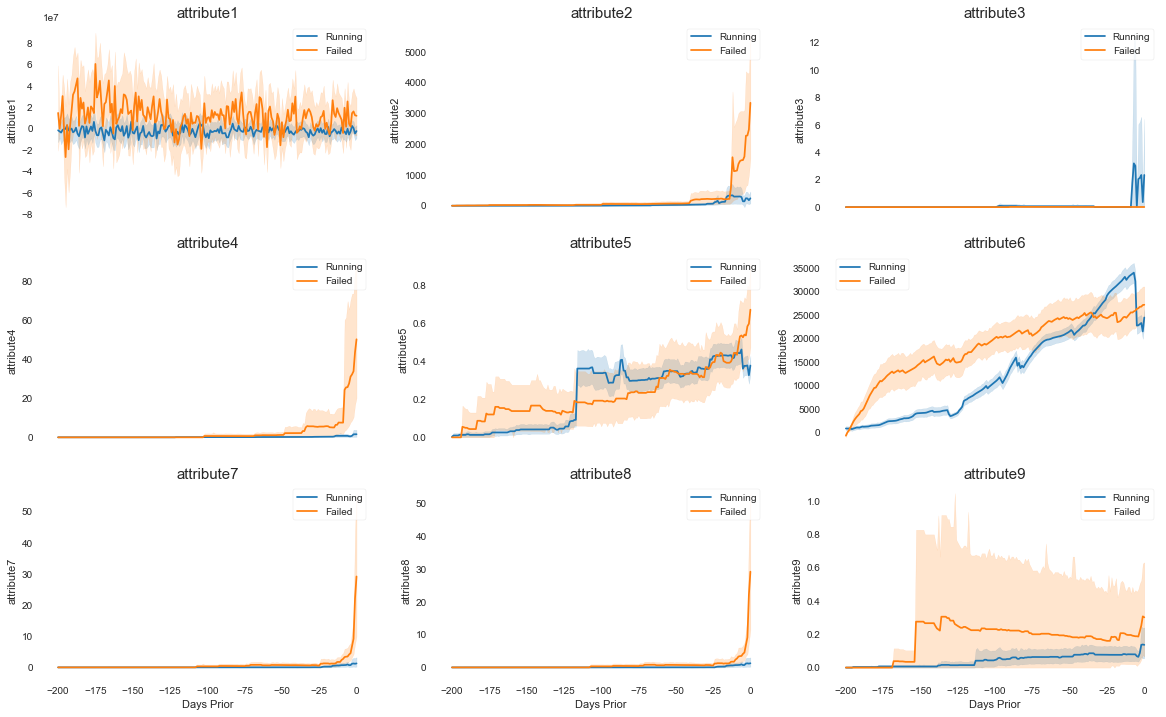

In [76]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df = (
    raw
    .sort_values(['device', 'date'])
    .assign(date=raw.date.astype('datetime64[ns]'))
    .groupby('device')
    .apply(lambda x: x
           .transform(lambda s: s - s.iloc[-min(200, s.shape[0])] if s.name not in ['date', 'device', 'failure', 'offset'] else s)
           .assign(
               days_prior=(x.date - max(x.date)).apply(lambda y: y.days),
               lifetime=(x.date - min(x.date)).apply(lambda y: y.days),
               failure=lambda s: s.failure.max())
          )
    .reset_index(drop=True)
    .pipe(lambda df: df.loc[df.days_prior >= -200, :])
)

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(20,12))

sub_groups = df.groupby('failure')

for ax, col in zip(axes.flatten(), df.columns[3:]):
    sub_groups.pipe(lambda g: [sns.lineplot(x='days_prior', y=col, data=d, label='Failed' if f else 'Running', ax=ax) for f,d in g])
    ax.set_title(col, size=15)
    ax.set_xlabel('Days Prior')

## Does Likelihood of Failure Increase Over Device Lifetime?
A knee jerk question is the hypothesis that devices age and fail as time goes on. Or, defective devices fail immediately.

#### Takeaway
Unfortunately this is not the case. When we sort devices by their lifetime (measured in days), failure happens across the board.

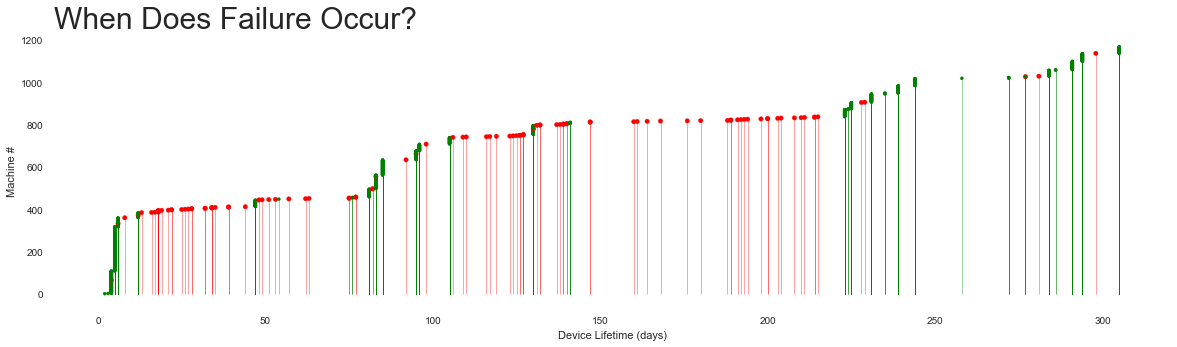

In [12]:
df = (
    raw
    .sort_values(['device', 'date'])
    .assign(date=raw.date.astype('datetime64[ns]'))
    .groupby('device')
    .agg(
        lifetime=('date', lambda x: (x.max() - x.min()).days), 
        failure=('failure', lambda x: x.max()))
    .reset_index(drop=True)
    .sort_values(['lifetime'])
)

# Reorder it following the values:
my_range=range(1, df.shape[0] + 1)
 
# Create a color if the group is "B"
my_color=np.where(df['failure']==1, 'red', 'green')
my_size=np.where(df['failure']==1, 20, 10)
 
# The vertival plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
fig, ax = plt.subplots(figsize=(20, 5))
ax.vlines(x=df['lifetime'], ymin=0, ymax=my_range, color=my_color, lw=.5, alpha=0.7)
ax.scatter(x=df['lifetime'], y=my_range, color=my_color, s=my_size, alpha=1)
 
# # Add title and exis names
# ax.set_yticks(my_range, df['failure'])
ax.set_xlabel('Device Lifetime (days)')
ax.set_ylabel('Machine #')
ax.set_title('When Does Failure Occur?', size=30, loc='left');

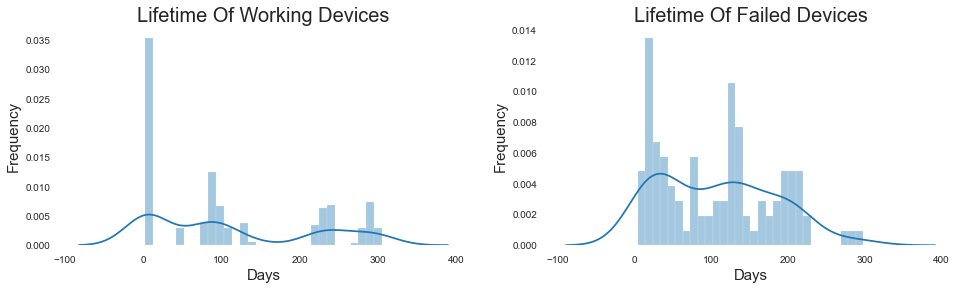

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,4))

(
    raw
    .sort_values(['device', 'date'])
    .assign(date=raw.date.astype('datetime64[ns]'))
    .groupby('device')
    .agg(
        lifetime=('date', lambda x: (x.max() - x.min()).days), 
        failure=('failure', lambda x: x.max()))
    .reset_index(drop=True)
    .groupby('failure')
    .pipe(lambda subgroup: [sns.distplot(d[1].lifetime, bins=30, ax=x, label=d[0]) for x, d in zip(axs.flatten(), subgroup)])
)

axs[0].set_title('Lifetime Of Working Devices', size=20)
axs[1].set_title('Lifetime Of Failed Devices', size=20)
[x.set_xlabel('Days', size=15) for x in axs];
[x.set_ylabel('Frequency', size=15) for x in axs];

# Calculate Deviation From Daily Statistics
Circling back on the anomolous behavior idea, perhaps there are wildly off signals coming from failed devices. Here we are comparing the daily readings of each device to a trailing 10 day average. We modify the values to describe how many standard deviations they are away from the average value of all device measurements that we have in a given date range. Then, we seperate the failed devices from the working and plot their values over time.

#### Takeaway
Attribute1 of failed devices has a much higher variability than working devices, and once again there are noticable spices in attributes 2, 4, 7 and 8.

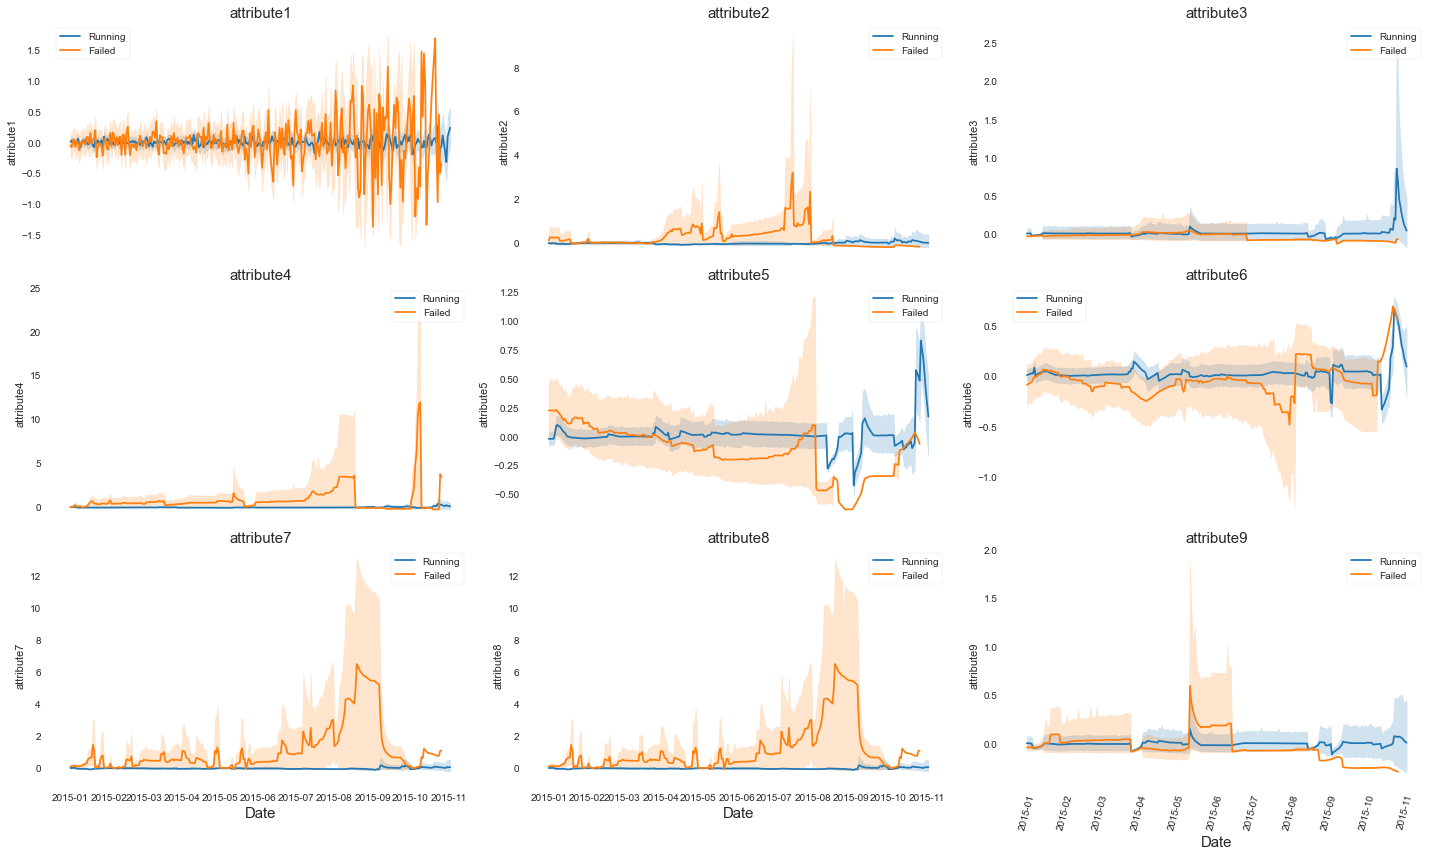

In [415]:
df = run['roll_normalization'].task.data.df

device_groups = (
    df
    .pipe(lambda d: 
          d.merge(
              right=d.groupby('device').agg(device_failure=('failure', lambda x: x.max())), 
              left_on='device', 
              right_index=True)
         )
    .groupby('device_failure')
)

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(20,12))

for failure_status, dataset in device_groups:
    label = 'Failed' if failure_status == 1 else 'Running'
    
    for ax, col in zip(axes.flatten(), dataset.columns[3:]):
        sns.lineplot(x='date', y=col, data=dataset, label=label, ax=ax)
        ax.set_title(col, size=15)
        ax.set_xlabel('Date', size=15)
        plt.xticks(rotation=75)
    
fig.tight_layout()

# Modeling Approach

I initially tried tackling this problem with single-class classifiers (unsupervised), hoping to group anomolous behavior together as my "positive" class (failed devices). However there was high bias in this model, and it failed to delineate the not-so-great signals coming from working devices as acceptable values.

After a lot of model tuning, I decided to switch back to a supervised learning model. I ended up with much better results using a Random Forest Classifier. 

The great thing about Tree Models, particularly Random Forest Classifiers, is that they are robust to outliers and less sensitive to non-normalized data. Intuitively, traditional systems would monitor values by using "gaurd rails"--namely if values crossed a certain threshold then the system would send notifications. Tree based models learn this technique by way of tree splits.


    Training | Number of devices per failure status
    failure
    0    850
    1     83
    Name: device, dtype: int64

    Validation | Number of devices per failure status
    failure
    0    213
    1     22
    Name: device, dtype: int64


**_For a detailed look at the model pipeline, please review pipeline.py_**

# Evaluation Strategy

I decided to tackle this problem via rolling probabilities over time per device. This means each day a prediction is made for each device, and if the ratio of "failing" predictions over a period of time crosses a threshold, then we would consider the device detected.

The model was trained on the latest data on a portion of devices and evaluated on the remainder. If the model overwhelmingly predicted "Fail" for the last few days of a device, we consider it a true prediction.

## Results

Our model did very well with detecting failure. It did not make any false positive predictions on the hold out set, and correctly detected 82% of the held out failed devices. 

In [505]:
run = Flow('Model').latest_successful_run

In [509]:
cm = run['train_evaluate'].task.data.confusion_matrix
pn = run['train_evaluate'].task.data.precision
results = run['train_evaluate'].task.data.results

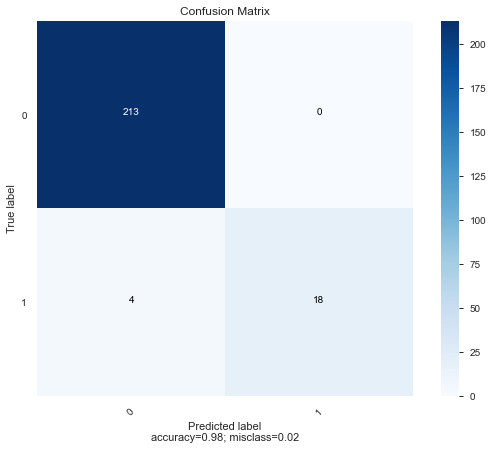

In [510]:
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy
target_names=[0, 1]
cmap = plt.get_cmap('Blues')
thresh = cm.max() / 1.5

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
plt.show()

    

In [512]:
print(metrics.classification_report(y_pred=results.detected, y_true=results.actual))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       213
           1       1.00      0.82      0.90        22

    accuracy                           0.98       235
   macro avg       0.99      0.91      0.95       235
weighted avg       0.98      0.98      0.98       235

